# Analysis of RNA across merged samples

# Set-up

In [1]:
# Import packages
import os
import sys
import yaml
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import snapatac2 as snap
import scipy.stats as stats
sc.settings.verbosity = 0

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set sc verbosity
sc.settings.verbosity = 0

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/.local/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [4]:
sys.path.append("/cellar/users/aklie/projects/igvf/single_cell_utilities")
from cell_type_annotation.utils import check_marker_genes
from plot.covariates import grouped_proportion_barplot, prettier_grouped_proportion_barplot, plot_cluster_counts, pretty_umap, combined_cluster_proportions

In [5]:
# config path
path_config = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/technology-benchmark_WTC11_TF-Perturb-seq/configs/analysis_gene.yaml"

In [10]:
# Read params from config
with open(path_config, "r") as f:
    config = yaml.safe_load(f)

path_h5ad = config["path_h5ad"]
path_sample_metadata = config["path_sample_metadata"]
path_outdir = config["path_outdir"]
counts_layer = config["counts_layer"]
umap_key = config["umap_key"]
pca_key = config["pca_key"]
clustering_key = config["clustering_key"]
categorical_covariates = config["categorical_covariates"]
continuous_covariates = config["continuous_covariates"]

print(f"Path h5ad: {path_h5ad}")
print(f"Path sample metadata: {path_sample_metadata}")
print(f"Path outdir: {path_outdir}")
print(f"Counts layer: {counts_layer}")
print(f"UMAP key: {umap_key}")
print(f"PCA key: {pca_key}")
print(f"Clustering key: {clustering_key}")
print(f"Categorical covariates: {categorical_covariates}")
print(f"Continuous covariates: {continuous_covariates}")

# Confirm they exist
assert os.path.exists(path_h5ad)

# Make figure directory
os.makedirs(os.path.join(path_outdir, "embeddings"), exist_ok=True)
os.makedirs(os.path.join(path_outdir, "clusters"), exist_ok=True)
os.makedirs(os.path.join(path_outdir, "cell_cycle_scoring"), exist_ok=True)

Path h5ad: /cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/technology-benchmark_WTC11_TF-Perturb-seq/results/reduce_dimensions/seurat_default_pca.h5ad
Path sample metadata: None
Path outdir: /cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/technology-benchmark_WTC11_TF-Perturb-seq/results
Counts layer: counts
UMAP key: X_seurat_default_umap
PCA key: X_seurat_default
Clustering key: leiden_1
Categorical covariates: ['sample']
Continuous covariates: ['percent_mito']


# Load and format data

In [9]:
# Read in AnnData
adata = sc.read_h5ad(path_h5ad)
bcs = adata.obs.index.tolist()
adata

AnnData object with n_obs × n_vars = 357980 × 7953
    obs: 'batch', 'cov1', 'batch_number', 'n_counts', 'log1p_n_genes_by_counts', 'total_gene_umis', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'percent_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'num_expressed_genes', 'sample', 'total_counts', 'leiden_1'
    var: 'sctransform_genes'
    obsm: 'X_seurat_default', 'X_seurat_default_umap', 'sctransform_scale_data'
    layers: 'log1p_norm'

In [11]:
# Load sample metadata
if path_sample_metadata:
    sample_metadata = pd.read_csv(path_sample_metadata, sep="\t")
    sample_metadata = sample_metadata.dropna(subset=["sample_id"])
    adata_obs = adata.obs.merge(sample_metadata, left_on="sample", right_on="sample_id", how="left")
    adata_obs.index = bcs
    adata.obs = adata_obs
adata.obs.head()

,batch,cov1,batch_number,n_counts,log1p_n_genes_by_counts,total_gene_umis,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,...,total_counts_mt,log1p_total_counts_mt,percent_mito,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,num_expressed_genes,sample,total_counts,leiden_1
Hon_WTC11-benchmark_TF-Perturb-seq#CCTATTAGTCCTCTTG_0,IGVFDS6244NAXC,1,1,3718,8.221210,8116.0,9.001716,17.471661,24.655002,32.811730,...,361.0,5.891644,4.448004,958.0,6.865891,11.803844,3718,Hon_WTC11-benchmark_TF-Perturb-seq,7356.0,0
Hon_WTC11-benchmark_TF-Perturb-seq#CTTTGCGAGTCAAGGC_0,IGVFDS6244NAXC,1,1,2897,7.971776,5822.0,8.669571,18.979732,27.001031,36.259018,...,124.0,4.828314,2.129852,831.0,6.723833,14.273445,2897,Hon_WTC11-benchmark_TF-Perturb-seq,5276.0,4
Hon_WTC11-benchmark_TF-Perturb-seq#GTAGTCAGTCTGGTCG_0,IGVFDS6244NAXC,1,1,2240,7.714677,4133.0,8.327001,19.743528,28.453908,37.575611,...,122.0,4.812184,2.951851,681.0,6.525030,16.477135,2240,Hon_WTC11-benchmark_TF-Perturb-seq,3830.0,0
Hon_WTC11-benchmark_TF-Perturb-seq#GCAATCAAGTCGTACT_0,IGVFDS6244NAXC,1,1,4567,8.426831,12907.0,9.465603,21.802123,29.852018,37.909661,...,863.0,6.761573,6.686294,1942.0,7.571989,15.046099,4567,Hon_WTC11-benchmark_TF-Perturb-seq,11814.0,4
Hon_WTC11-benchmark_TF-Perturb-seq#CCCAATCAGACGACGT_0,IGVFDS6244NAXC,1,1,1743,7.463937,3194.0,8.069343,25.328741,33.594239,43.613024,...,302.0,5.713733,9.455229,497.0,6.210600,15.560426,1743,Hon_WTC11-benchmark_TF-Perturb-seq,2925.0,11


In [12]:
# Change variable names
adata.obsm["X_umap"] = adata.obsm[umap_key]
adata.obsm["X_pca"] = adata.obsm[pca_key]
adata

AnnData object with n_obs × n_vars = 357980 × 7953
    obs: 'batch', 'cov1', 'batch_number', 'n_counts', 'log1p_n_genes_by_counts', 'total_gene_umis', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'percent_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'num_expressed_genes', 'sample', 'total_counts', 'leiden_1'
    var: 'sctransform_genes'
    obsm: 'X_seurat_default', 'X_seurat_default_umap', 'sctransform_scale_data', 'X_umap', 'X_pca'
    layers: 'log1p_norm'

In [13]:
# Merge PC values
pcs = pd.DataFrame(adata.obsm["X_pca"][:, :10], columns=[f"PC{i}" for i in range(1, 11)], index=adata.obs.index)
adata.obs = pd.concat([adata.obs, pcs], axis=1)
adata.obs.head()

,batch,cov1,batch_number,n_counts,log1p_n_genes_by_counts,total_gene_umis,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Hon_WTC11-benchmark_TF-Perturb-seq#CCTATTAGTCCTCTTG_0,IGVFDS6244NAXC,1,1,3718,8.221210,8116.0,9.001716,17.471661,24.655002,32.811730,...,2.311340,13.868189,4.952165,-6.629882,2.239142,4.945891,3.330955,-0.809213,-3.849690,-2.409700
Hon_WTC11-benchmark_TF-Perturb-seq#CTTTGCGAGTCAAGGC_0,IGVFDS6244NAXC,1,1,2897,7.971776,5822.0,8.669571,18.979732,27.001031,36.259018,...,-1.780392,17.750393,3.417105,0.862746,1.951546,4.439011,-6.829092,-2.856591,4.879203,1.684418
Hon_WTC11-benchmark_TF-Perturb-seq#GTAGTCAGTCTGGTCG_0,IGVFDS6244NAXC,1,1,2240,7.714677,4133.0,8.327001,19.743528,28.453908,37.575611,...,-9.543956,11.349760,3.129126,-0.724512,-1.272008,-3.355504,0.580380,1.776867,-0.081855,0.178847
Hon_WTC11-benchmark_TF-Perturb-seq#GCAATCAAGTCGTACT_0,IGVFDS6244NAXC,1,1,4567,8.426831,12907.0,9.465603,21.802123,29.852018,37.909661,...,-7.223117,20.450682,5.803907,-1.511540,-2.477597,-0.371671,2.338588,3.500938,-3.680537,-0.058427
Hon_WTC11-benchmark_TF-Perturb-seq#CCCAATCAGACGACGT_0,IGVFDS6244NAXC,1,1,1743,7.463937,3194.0,8.069343,25.328741,33.594239,43.613024,...,-21.074323,12.434396,1.627725,1.285127,0.123745,-1.855869,-2.512479,1.972410,1.250812,1.194420


# Calcluate correlations with PCs

In [14]:
# Get ANOVA results for categorical variables
embeddings_anova_df = dc.get_metadata_associations(
    data=[pcs, adata.obs],
    obs_keys=categorical_covariates,
)
embeddings_anova_df["-log10(p_adj)"] = -np.log10(embeddings_anova_df["p_adj"])
embeddings_anova_df.to_csv(os.path.join(path_outdir, "embeddings", "embeddings_anova.csv"))
embeddings_anova_df.head()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,variable,pval,eta_sq,factor,p_adj,-log10(p_adj)
0,sample,0.0,0.604375,PC1,0.0,inf
1,sample,0.0,0.781793,PC2,0.0,inf
2,sample,0.0,0.049041,PC3,0.0,inf
3,sample,0.0,0.033827,PC4,0.0,inf
4,sample,0.0,0.084183,PC5,0.0,inf


In [15]:
# Spearman correlations between PCs and continuous covariates
embeddings_spearman_list = []
for pc in pcs.columns:
    for cov in continuous_covariates:
        rho, p = stats.spearmanr(pcs[pc], adata.obs[cov])
        embeddings_spearman_list.append([pc, cov, rho, p])
embeddings_spearman_df = pd.DataFrame(embeddings_spearman_list, columns=["PC", "covariate", "rho", "p"])
embeddings_spearman_df["-log10(p)"] = -np.log10(embeddings_spearman_df["p"])
embeddings_spearman_df.to_csv(os.path.join(path_outdir, "embeddings", "embeddings_spearman.csv"))
embeddings_spearman_df.head()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PC,covariate,rho,p,-log10(p)
0,PC1,percent_mito,0.005658,0.000712,3.147814
1,PC2,percent_mito,0.104038,0.000000,inf
2,PC3,percent_mito,-0.163758,0.000000,inf
3,PC4,percent_mito,0.068606,0.000000,inf
4,PC5,percent_mito,-0.090863,0.000000,inf


In [16]:
# For the highest ANOVA eta_sq, plot a violinplot of the PCs vs the categorical variable
eta_sq_cutoff = 0.1
eta_sq_df = embeddings_anova_df[embeddings_anova_df["eta_sq"] > eta_sq_cutoff]

# Plot
for i, row in eta_sq_df.iterrows():
        fig, ax = plt.subplots(figsize=(10, 5))
        pc = row["factor"]
        cov = row["variable"]
        eta_sq = row["eta_sq"]
        sns.violinplot(
            x=cov,
            y=pc,
            data=adata.obs,
            ax=ax,
        )
        plt.title(f"{pc} vs {cov} (eta_sq={eta_sq:.2f})")
        plt.savefig(os.path.join(path_outdir, "embeddings", f"{pc}_vs_{cov}.png"), bbox_inches="tight")    
        plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this 

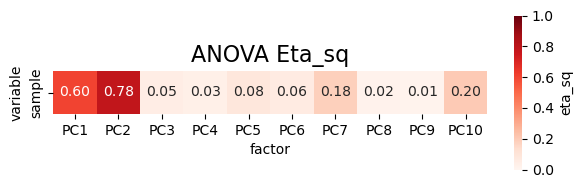

In [17]:
# Make a pretty heatmap of eta_sq for PC vs variable 
heatmap_df = embeddings_anova_df.pivot(index="variable", columns="factor", values="eta_sq")
heatmap_df = heatmap_df.dropna(axis=0, how="all")
heatmap_df = heatmap_df[pcs.columns]
fig, ax = plt.subplots(figsize=(7, 2))
sns.heatmap(heatmap_df, annot=True, cmap="Reds", ax=ax, cbar_kws={"label": "eta_sq"}, fmt=".2f", square=True, vmin=0, vmax=1)
plt.title("ANOVA Eta_sq", fontsize=16)
plt.savefig(os.path.join(path_outdir, "embeddings", "eta_sq_heatmap.png"), bbox_inches="tight")

In [19]:
# Pick two PCs and a covariate to plot nicely with large x and y labels and a legend title
pc1 = "2"
pc2 = "3"
covariate = "sample"
with plt.rc_context({'axes.labelsize' : 'x-large'}):
    ax = sc.pl.pca(adata, color=covariate, components=[pc1+","+pc2], legend_fontsize=12, show=False)
    plt.savefig(os.path.join(path_outdir, "embeddings", f"pca_{pc1}_{pc2}_vs_{covariate}.png"), bbox_inches="tight")
    plt.close()

In [20]:
# For the highest spearman rho, plot a scatterplot of the PCs vs the continuous variable
rho_cutoff = 0.3
rho_df = embeddings_spearman_df[embeddings_spearman_df["rho"].abs() > rho_cutoff]

# Plot
for i, row in rho_df.iterrows():
        fig, ax = plt.subplots(figsize=(10, 5))
        pc = row["PC"]
        cov = row["covariate"]
        rho = row["rho"]
        sns.scatterplot(
            x=cov,
            y=pc,
            data=adata.obs,
            ax=ax,
        )
        plt.title(f"{pc} vs {cov} (rho={rho:.2f})")
        plt.savefig(os.path.join(path_outdir, "embeddings", f"{pc}_vs_{cov}.png"), bbox_inches="tight")    
        plt.close()

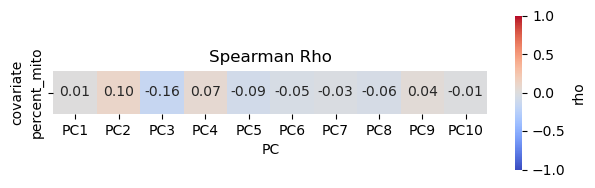

In [21]:
# Make a pretty heatmap of rho for PC vs variable
heatmap_df = embeddings_spearman_df.pivot(index="covariate", columns="PC", values="rho")
heatmap_df = heatmap_df.dropna(axis=1, how="all")
heatmap_df = heatmap_df[pcs.columns]
fig, ax = plt.subplots(figsize=(7, 2))
sns.heatmap(heatmap_df, annot=True, cmap="coolwarm", ax=ax, vmin=-1, vmax=1, cbar_kws={"label": "rho"}, fmt=".2f", square=True)
plt.title("Spearman Rho")
plt.savefig(os.path.join(path_outdir, "embeddings", "rho_heatmap.png"), bbox_inches="tight")

In [23]:
# Pick a PC and a covariate to plot nice scatterplot with large x and y labels
pc = "PC3"
covariate = "percent_mito"
with plt.rc_context({'axes.labelsize' : 'x-large'}):
    ax = sc.pl.scatter(adata, x=covariate, y=pc, show=False, palette="viridis")
    plt.savefig(os.path.join(path_outdir, "embeddings", f"{pc}_vs_{covariate}.png"), bbox_inches="tight")
    plt.close()

# Plot dimensionality reductions

In [24]:
# pca plots
for cov in categorical_covariates + continuous_covariates:
    with plt.rc_context({'axes.facecolor':'white', 'figure.facecolor':'white'}):
        sc.pl.pca(adata, color=[cov], show=False, components=["1,2", "3,4", "5,6", "7,8", "9,10", "11,12"], ncols=3, wspace=0.2)
        plt.savefig(os.path.join(path_outdir, "embeddings", f"embeddings_{cov}.png"), bbox_inches="tight")
        plt.close()

In [25]:
# Unsupervised clustering
with plt.rc_context({'axes.facecolor':'white', 'figure.facecolor':'white'}):
    sc.pl.umap(adata, color=[clustering_key] + categorical_covariates, ncols=2, wspace=0.2, size=1, show=False)
    plt.savefig(os.path.join(path_outdir, "embeddings", "umap_categorical.png"), bbox_inches="tight")
    plt.close()
with plt.rc_context({'axes.facecolor':'white', 'figure.facecolor':'white'}):
    sc.pl.umap(adata, color=[clustering_key] + continuous_covariates, ncols=2, wspace=0.2, size=1, show=False)
    plt.savefig(os.path.join(path_outdir, "embeddings", "umap_continuous.png"), bbox_inches="tight")
    plt.close()

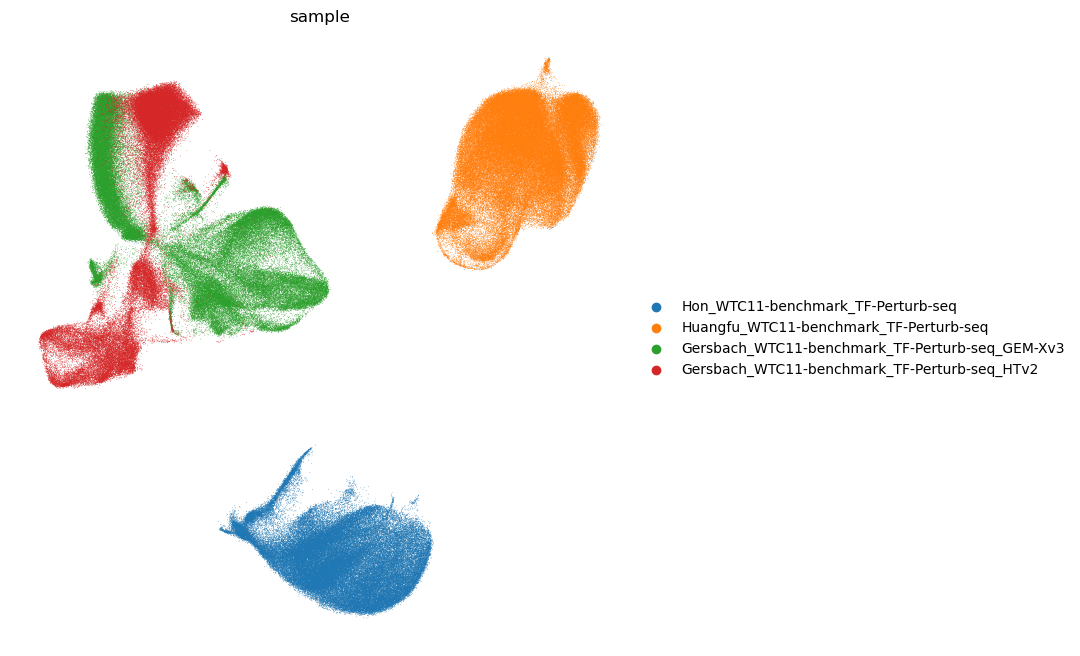

In [26]:
# Pick a continuous covariate to plot nice scatterplot with large x and y labels and title
covariate = "sample"
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sc.pl.umap(adata, color=covariate, show=False, frameon=False, ax=ax, s=1)
plt.savefig(os.path.join(path_outdir, "embeddings", f"umap_{covariate}.png"), bbox_inches="tight")

In [31]:
pretty_umap(
    adata,
    color_key=clustering_key,
    save=os.path.join(path_outdir, "embeddings", f"pretty_umap_{clustering_key}.png"),
    s=1
)

In [32]:
pretty_umap(
    adata,
    color_key="sample",
    save=os.path.join(path_outdir, "embeddings", f"pretty_umap_sample.png"),
    s=1
)

# Cluster analysis

In [33]:
# Useful for plotting overall proportions of clusters
adata.obs["assay"] = "TF-Perturb-seq"

In [34]:
# Sort the clusters numerically
cluster_order = sorted(adata.obs[clustering_key].unique(), key=lambda x: int(x))[::-1]
cluster_order

['21',
 '20',
 '19',
 '18',
 '17',
 '16',
 '15',
 '14',
 '13',
 '12',
 '11',
 '10',
 '9',
 '8',
 '7',
 '6',
 '5',
 '4',
 '3',
 '2',
 '1',
 '0']

In [35]:
# QC violin plots
with plt.rc_context({"figure.figsize": (7, 5)}):
    sc.pl.violin(adata, keys=continuous_covariates, groupby=clustering_key, show=False)
    plt.savefig(os.path.join(path_outdir, "clusters", "qc_violin.png"), bbox_inches="tight")
    plt.close()

... storing 'assay' as categorical


2025-12-02 14:27:45 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-02 14:27:45 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-02 14:27:45 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-02 14:27:46 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-02 14:27:46 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

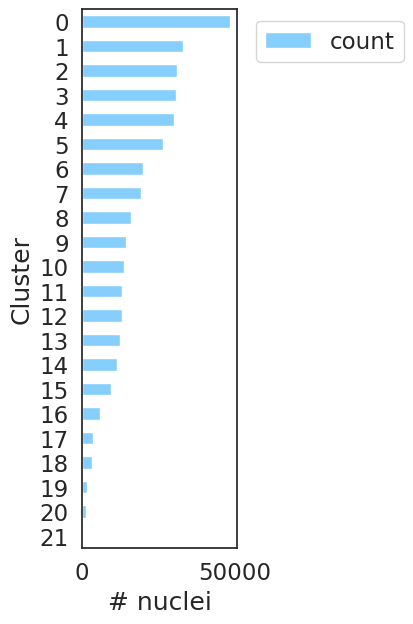

In [36]:
# Counts of cells
plot_cluster_counts(
    adata,
    clustering_key,
    save=os.path.join(path_outdir, "clusters", "cluster_counts.png"),
)
plt.close()

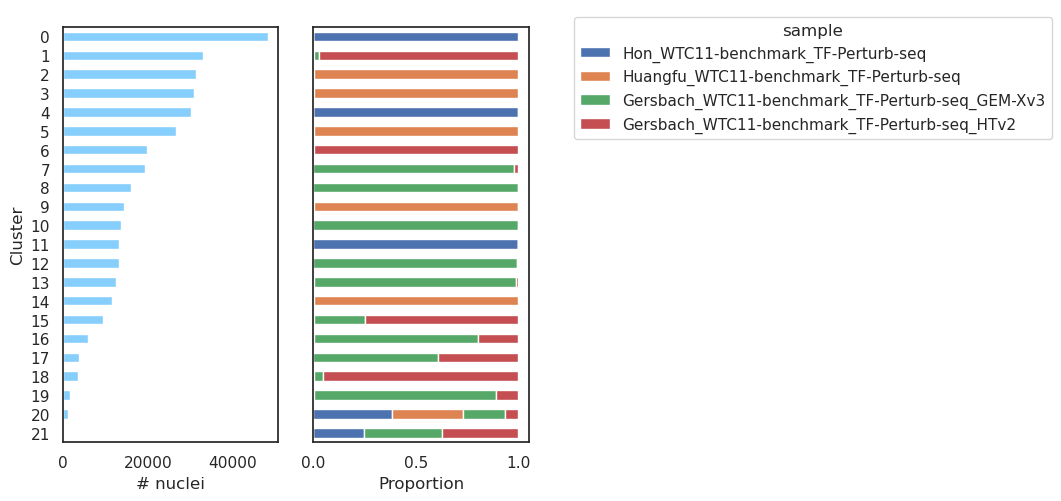

In [37]:
# Usage example
combined_cluster_proportions(
    adata=adata,
    clustering_key=clustering_key,
    proportion_keys=categorical_covariates,
    cluster_order=cluster_order,
    colors_dicts=[None, None, None],
    figsize=(7, 5),
    title="",
    fontscale=1,
    save=os.path.join(path_outdir, "clusters", "combined_proportions.png")
)

In [38]:
%%capture
for covariate in categorical_covariates:

    # if covariate is sample make figsize (10, 18) else 5,12
    if covariate == "sample":
        figsize = (10, 18)
        annot = False
        first = covariate
        second = clustering_key
        
    else:
        figsize = (5, 12)
        annot = True
        first = clustering_key
        second = covariate
    
    # 1. Plot total counts
    plot_cluster_counts(
        adata,
        covariate,
        save=os.path.join(path_outdir, "clusters", f"{covariate}_counts.png"),
    )

    # 2. Plot heatmap of counts per cluster
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        pd.crosstab(adata.obs[first], adata.obs[second]),
        annot=annot, 
        annot_kws={"size": 8}, 
        fmt="d", 
        cmap="Blues",
        ax=ax
    )
    plt.savefig(os.path.join(path_outdir, "clusters", f"{covariate}_counts_by_cluster_heatmap.png"), bbox_inches="tight")

    # 3. Same heatmap but normalized by row
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        pd.crosstab(adata.obs[first], adata.obs[second], normalize="index"), 
        annot=annot, 
        annot_kws={"size": 8}, 
        fmt=".2f", 
        cmap="Blues",
        ax=ax
    )
    plt.savefig(os.path.join(path_outdir, "clusters", f"{covariate}_counts_by_cluster_heatmap_normalized.png"), bbox_inches="tight")

    # 4. Plot just barplot of proportions by cluster
    prettier_grouped_proportion_barplot(
        adata,
        groupby_key=clustering_key,
        proportion_key=covariate,
        groupby_order=cluster_order,
        save=os.path.join(path_outdir, "clusters", f"{covariate}_proportions_by_cluster.png"),
    )
    prettier_grouped_proportion_barplot(
        adata,
        groupby_key="assay",
        proportion_key=covariate,
        figsize=(2, 1),
        save=os.path.join(path_outdir, "clusters", f"{covariate}_proportions_overall.png"),
    )

# Marker gene analysis

In [39]:
# Find markers for all leiden_1 clusters
sc.tl.rank_genes_groups(
    adata, 
    groupby=clustering_key, 
    method="wilcoxon", 
    layer="log1p_norm", 
    use_raw=False
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/pytho

In [41]:
# Plot markers
with plt.rc_context({"figure.figsize": (7, 5)}):
    sc.pl.rank_genes_groups(adata, n_genes=25, groupby=clustering_key, show=False)
    plt.savefig(os.path.join(path_outdir, "marker_genes", "cluster_markers.png"), bbox_inches="tight")
    plt.close()

In [42]:
# Save a tsv for each cluster
for cluster in adata.obs[clustering_key].unique():
    markers = adata.uns["rank_genes_groups"]["names"][cluster]
    scores = adata.uns["rank_genes_groups"]["scores"][cluster]
    pvals = adata.uns["rank_genes_groups"]["pvals"][cluster]
    pvals_adj = adata.uns["rank_genes_groups"]["pvals_adj"][cluster]
    logfoldchanges = adata.uns["rank_genes_groups"]["logfoldchanges"][cluster]
    reference = [adata.uns["rank_genes_groups"]["params"]["reference"]]*len(markers)
    markers = pd.DataFrame(
        {
            "gene": markers,
            "score": scores,
            "pval": pvals,
            "pval_adj": pvals_adj,
            "logfoldchange": logfoldchanges,
            "reference": reference,
        }
    )
    markers.to_csv(os.path.join(path_outdir, "marker_genes", f"{clustering_key}_{cluster}_markers.tsv"), sep="\t")
    
    # Also just save top 50 as txt
    markers.head(50)["gene"].to_csv(os.path.join(path_outdir, "marker_genes", f"{clustering_key}_{cluster}_top50.txt"), index=False, header=False)

# Cell cycle scoring

In [43]:
# Get cell cycle genes
cell_cycle_genes = [x.strip() for x in open('/cellar/users/aklie/projects/igvf/single_cell_utilities/resources/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [44]:
# Save raw in adata
adata.raw = adata

In [45]:
# Filter for cell cycle genes only
adata_cc = adata[:, cell_cycle_genes].copy()

In [46]:
# scale, note that .X contains scaled data now
sc.pp.scale(adata_cc)

In [47]:
# Score genes
sc.tl.score_genes_cell_cycle(adata_cc, s_genes=s_genes, g2m_genes=g2m_genes)

ValueError: No valid genes were passed for scoring.

In [ ]:
# Plot cell cycle scores as UMAP
with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata_cc, color=["S_score", "G2M_score", "phase"], cmap="bwr", vmin="p0", vmax="p99.9", ncols=3, s=20, wspace=0.2, show=False)
    plt.savefig(os.path.join(path_outdir, "cell_cycle_scoring", "cell_cycle_umap.png"), bbox_inches="tight")
    plt.close()

... storing 'phase' as categorical
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [ ]:
# Transfer cell cycle scores to main adata
adata.obs["S_score"] = adata_cc.obs["S_score"].copy()
adata.obs["G2M_score"] = adata_cc.obs["G2M_score"].copy()
adata.obs["phase"] = adata_cc.obs["phase"].copy()

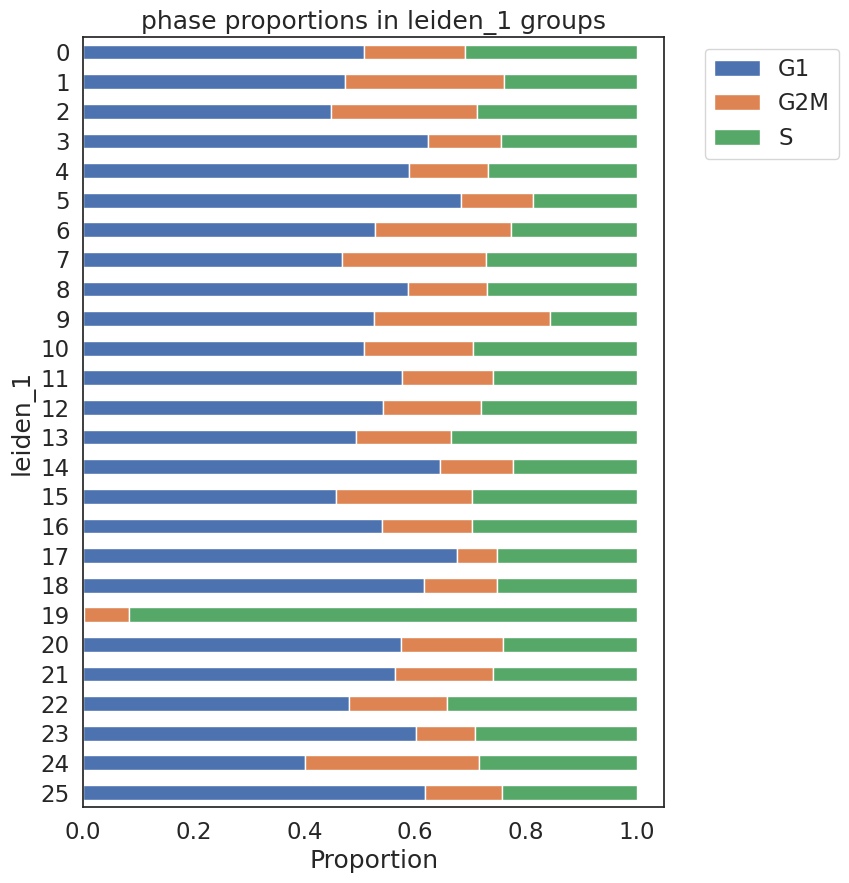

In [ ]:
# Plot cluster proportions by phase
grouped_proportion_barplot(
    adata,
    groupby_key=clustering_key,
    proportion_key="phase",
    groupby_order=cluster_order,
    save=os.path.join(path_outdir, "clusters", "phase_proportions_by_cluster.png")
)

## PROGENy multivariate linear model

In [ ]:
# Make counts to use log1p_norm
adata.X = adata.layers["log1p_norm"].copy()

In [ ]:
# Grab progeny gene weights
progeny = dc.get_progeny(organism='human', top=500)
progeny

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-25 22:04:40 - INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-08-25 22:04:41 - INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-08-25 22:04:42 - INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-08-25 22:04:42 - INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-08-25 22:04:43 - INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-08-25 22:04:43 - INFO - Downloading data from `https://omnipathdb.org/about?format=text`
2024-08-25 22:04:44 - INFO - Downloading annotations for all proteins from the foll

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


In [ ]:
# Run MLM
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
)

1629 features of mat are empty, they will be removed.
Running mlm on mat with 296175 samples and 34972 targets for 14 sources.


100%|██████████| 30/30 [19:36<00:00, 39.21s/it]


In [ ]:
# Clean up MLM results
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 296175 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

In [ ]:
# Get the activities as new AnnData
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 296175 × 14
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fragm

In [44]:
# Some visualizations
with plt.rc_context({"figure.figsize": (7, 5)}):
    sc.pl.violin(acts, groupby="condition", keys="JAK-STAT", rotation=90, show=False)
    plt.savefig(os.path.join(path_outdir, "pathways", "JAK-STAT_violin.png"), bbox_inches="tight")
    plt.close()
with plt.rc_context({"figure.figsize": (7, 5)}):
    sc.pl.violin(acts, groupby="condition", keys="TNFa", rotation=90, show=False)
    plt.savefig(os.path.join(path_outdir, "pathways", "TNFa_violin.png"), bbox_inches="tight")
    plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9

## Over representation analysis with MSigDB hallmark

In [45]:
# Get MSigDB
msigdb = dc.get_resource('MSigDB')
msigdb

2024-08-25 22:25:46 - INFO - Downloading annotations for all proteins from the following resources: `['MSigDB']`


,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [46]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

,genesymbol,collection,geneset
233,MAFF,hallmark,HALLMARK_IL2_STAT5_SIGNALING
250,MAFF,hallmark,HALLMARK_COAGULATION
270,MAFF,hallmark,HALLMARK_HYPOXIA
373,MAFF,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,HALLMARK_COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450526,GCG,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,HALLMARK_PANCREAS_BETA_CELLS


In [47]:
# Run ORA
dc.run_ora(
    mat=adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
    use_raw=False,
)

1629 features of mat are empty, they will be removed.
Running ora on mat with 296175 samples and 34972 targets for 50 sources.


100%|██████████| 296175/296175 [13:06<00:00, 376.41it/s]


In [48]:
# Clean up ORA results
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e
acts

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 296175 × 50
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fragm

In [49]:
# Rank sources
df = dc.rank_sources_groups(acts, groupby='condition', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,3-cyt,rest,HALLMARK_INTERFERON_GAMMA_RESPONSE,69.869884,0.317457,0.000000e+00,0.000000e+00
1,3-cyt,rest,HALLMARK_INTERFERON_ALPHA_RESPONSE,66.951401,0.332620,0.000000e+00,0.000000e+00
2,3-cyt,rest,HALLMARK_IL6_JAK_STAT3_SIGNALING,58.700267,0.042070,0.000000e+00,0.000000e+00
3,3-cyt,rest,HALLMARK_ALLOGRAFT_REJECTION,45.930324,0.015977,0.000000e+00,0.000000e+00
4,3-cyt,rest,HALLMARK_INFLAMMATORY_RESPONSE,35.912987,0.018549,7.972229e-279,7.972229e-278
...,...,...,...,...,...,...,...
295,palmitate,rest,HALLMARK_IL6_JAK_STAT3_SIGNALING,-24.911679,-0.008261,1.251981e-136,2.608294e-136
296,palmitate,rest,HALLMARK_ALLOGRAFT_REJECTION,-32.037577,-0.004698,4.145420e-224,1.381807e-223
297,palmitate,rest,HALLMARK_KRAS_SIGNALING_DN,-43.994543,-0.030979,0.000000e+00,0.000000e+00
298,palmitate,rest,HALLMARK_INTERFERON_GAMMA_RESPONSE,-52.054086,-0.082574,0.000000e+00,0.000000e+00


In [50]:
# Save top 3 markers
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'3-cyt': ['HALLMARK_INTERFERON_GAMMA_RESPONSE',
  'HALLMARK_INTERFERON_ALPHA_RESPONSE',
  'HALLMARK_IL6_JAK_STAT3_SIGNALING'],
 'Ex-4_HG': ['HALLMARK_ANDROGEN_RESPONSE',
  'HALLMARK_APICAL_SURFACE',
  'HALLMARK_ADIPOGENESIS'],
 'IFNg': ['HALLMARK_INTERFERON_ALPHA_RESPONSE',
  'HALLMARK_KRAS_SIGNALING_DN',
  'HALLMARK_INTERFERON_GAMMA_RESPONSE'],
 'control': ['HALLMARK_UV_RESPONSE_DN',
  'HALLMARK_PANCREAS_BETA_CELLS',
  'HALLMARK_APICAL_JUNCTION'],
 'dex': ['HALLMARK_MYOGENESIS',
  'HALLMARK_KRAS_SIGNALING_DN',
  'HALLMARK_APICAL_SURFACE'],
 'palmitate': ['HALLMARK_UV_RESPONSE_DN',
  'HALLMARK_PROTEIN_SECRETION',
  'HALLMARK_HEDGEHOG_SIGNALING']}

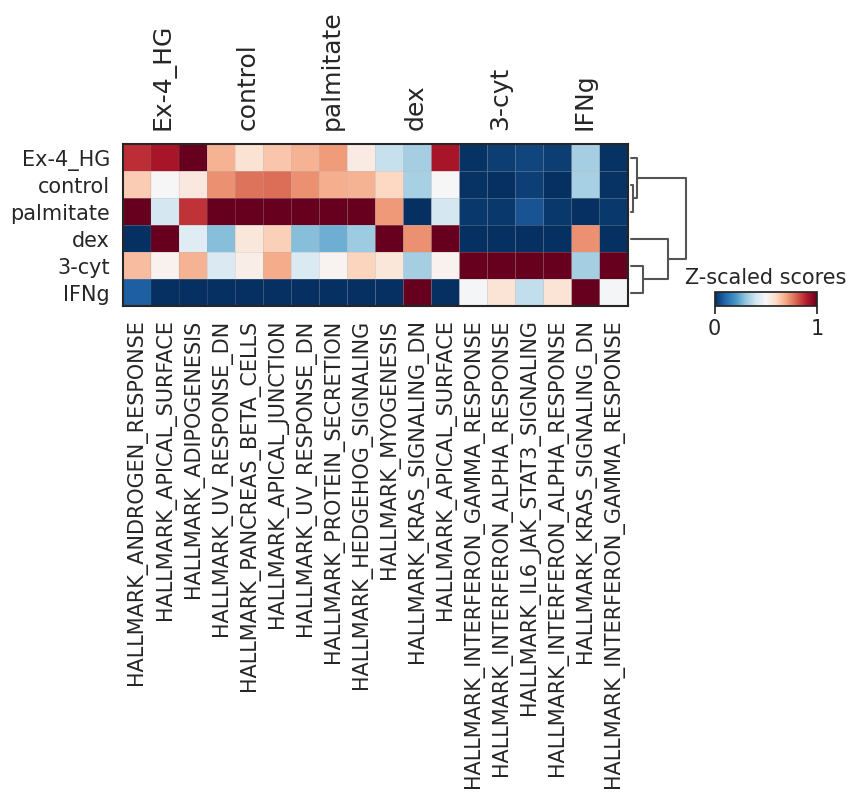

In [51]:
# If there are more than 2 conditions, we can use a heatmap
if len(adata.obs['condition'].unique()) > 2:
    sc.pl.matrixplot(
        acts, 
        source_markers, 
        'condition', 
        dendrogram=True, 
        standard_scale='var',
        colorbar_title='Z-scaled scores', 
        cmap='RdBu_r'
    )
else:
    print("Not enough conditions to plot heatmap")

In [52]:
# combine the lists for each ket into one list
all_markers = []
for key in source_markers.keys():
    all_markers += source_markers[key]
for marker in all_markers:
    with plt.rc_context({"figure.figsize": (7, 5)}):
        sc.pl.violin(acts, groupby='condition', keys=marker, rotation=90, show=False)
        plt.savefig(os.path.join(path_outdir, "pathways", f"{marker}_violin.png"), bbox_inches="tight")
        plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9

# DONE!

---

# Scratch